# Random forest for pianist classification

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, ParameterSampler, train_test_split
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.features_utils import PhaseCorrection, BeatUpbeatRatio, IOIComplexity, TempoSlope, ProportionalAsynchrony, RollingIOISummaryStats
from src.detect.detect_utils import OnsetMaker
from src.visualise.random_forest_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 10000

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Define predictor and prediction variables, get mappings

In [4]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [5]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano_drums', 'coupling_piano_bass'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [6]:
# This creates a dictionary for mapping a predictor onto its category
CATEGORY_MAPPING = {}
for pred in PREDICTORS:
    for category in PREDICTORS_CATEGORIES.keys():
        if pred in PREDICTORS_CATEGORIES[category]:
            CATEGORY_MAPPING[pred] = category

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [7]:
onsets: list[OnsetMaker] = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [8]:
def get_feature_data(feature_cls, cols, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [9]:
def process_track(track: OnsetMaker) -> dict:
    """Processes a single track, extracting all required features, and returns a dictionary"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_manual']
    # The tempo and time signature of the track
    tempo = track.tempo
    time_signature = track.item['time_signature']
    # Subset to get my onsets and partner onsets as separate dataframes
    my_onsets = track.ons[EXOG_INS]
    my_beats = summary_dict[EXOG_INS]
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != EXOG_INS]]
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PHASE CORRECTION - PARTNER
    # In comparison to the 'full' phase correction model, we only need to get a few columns here
    pcb = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_bass',
        my_beats=summary_dict['bass'], their_beats=summary_dict[['piano', 'drums']], order=1
    )
    pcd = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_drums',
        my_beats=summary_dict['drums'], their_beats=summary_dict[['piano', 'bass']], order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony, ['prop_async_count_nonzero', 'bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
        summary_df=summary_dict, my_instr_name=EXOG_INS
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, ['tempo_slope', 'tempo_drift'],
        my_beats=pd.concat([my_beats, their_beats], axis=1).mean(axis=1)
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **bur, **pc, **pcb, **pcd, **pa, **ioi, **ts, **tstab, tempo=tempo)

Now, we extract features from all tracks in parallel (should take < 5 minutes)

In [10]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [11]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

In [12]:
df.head()

,track_name,album_name,recording_year,pianist,channel_overrides,mbz_id,notes,time_signature,first_downbeat,rating_bass_audio,rating_bass_detection,rating_drums_audio,rating_drums_detection,rating_mix,rating_piano_audio,rating_piano_detection,rating_comments,has_annotations,links,excerpt_duration,timestamps,log,musicians,photos,fname,bur_log_mean,bur_log_std,bur_log_count_nonzero,coupling_bass,coupling_drums,self_coupling,nobs,coupling_piano_bass,nobs_bass,coupling_piano_drums,nobs_drums,prop_async_count_nonzero,bass_prop_async_nanmean,drums_prop_async_nanmean,bass_prop_async_nanstd,drums_prop_async_nanstd,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,tempo_slope,tempo_drift,rolling_std_median,rolling_std_count_nonzero,tempo
0,Poor Butterfly,Complete Live at the Pershing Lounge 1958,1958,Ahmad Jamal,{},94f90cba-f3c7-4a05-b86a-e30fd9ebe989,rim clicks have to be sticks,4,6.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,00:50,"{'start': '02:17', 'end': '03:07'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Israel ...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-poorbutterfly-crosbyifournierv-1958-94f...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030976,0.058693,NaN,0,140.064796
1,Tranquility,Tranquility,1967,Ahmad Jamal,{'bass': 'l'},4cc954d6-1e00-4bfd-b0e3-d12d2b5f853b,,4,15.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:36,"{'start': '02:01', 'end': '06:37'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-tranquility-nasserjgantf-1967-4cc954d6,0.188277,0.912414,155,0.187913,0.784486,-0.523532,256.0,0.092367,306.0,0.093327,421.0,487,0.005624,0.014426,0.001091,0.008556,12.251613,1.577412,32.819355,6.372089,0.007916,0.003653,0.222142,155,138.603562
2,Where Are You,In Search of Momentum 110,2002,Ahmad Jamal,{},a1295aa8-78ab-4234-a8a9-f05c1916d2d8,,4,8.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,03:06,"{'start': '01:24', 'end': '04:30'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'James C...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-whereareyou-cammackjmuhammadi-2002-a129...,0.229792,0.818012,131,0.235178,0.916245,-0.520223,89.0,0.081562,161.0,0.119725,202.0,355,0.008551,0.016082,0.005224,0.008087,11.174242,1.943854,25.507576,7.448035,-0.014056,0.009137,0.222306,132,175.652227
3,I Didnt Know What Time It Was,Emerald City Nights Live At The Penthouse 1965...,1966,Ahmad Jamal,{},d41671ba-f977-41b4-8108-8c4d17f54689,,4,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,04:03,"{'start': '03:54', 'end': '07:57'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Jamil N...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-ididntknowwhattime-nasserjlampkinc-1966...,0.108574,0.519236,41,0.116213,0.696361,-0.708782,9.0,0.123296,12.0,0.203917,22.0,161,0.010366,0.012084,0.003024,0.007217,6.783019,3.180311,11.311321,6.984831,0.032167,0.009975,0.120081,104,277.098382
4,Waltz for Debbie,Live at Bubbas,1980,Ahmad Jamal,{},0c9b07cd-2553-4899-8451-fcd74a53a739,,4,12.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,{'external': ['https://www.youtube.com/watch?v...,02:00,"{'start': '03:10', 'end': '05:10'}",[],"{'pianist': 'Ahmad Jamal', 'bassist': 'Sabu Ad...","{'musicians': {'pianist': None, 'bassist': Non...",jamala-waltzfordebbie-adeyolascrossleyp-1980-0...,0.562737,0.751594,23,NaN,NaN,NaN,NaN,NaN,NaN,-0.000092,1.0,55,0.003133,0.015614,-0.021554,0.011918,6.659091,3.443519,12.659091,8.476899,0.118093,0.017419,0.135465,36,195.038462


## Plot correlations between features
Before we clean outliers, we should plot the correlations between the raw values

In [70]:
df[PREDICTORS].isna().sum()

bur_log_mean                 2
bur_log_std                  2
lz77_mean                    2
lz77_std                     2
n_onsets_mean                2
n_onsets_std                 2
bass_prop_async_nanmean     11
drums_prop_async_nanmean     2
bass_prop_async_nanstd      12
drums_prop_async_nanstd      3
self_coupling               19
coupling_drums              19
coupling_bass               19
coupling_piano_drums        18
coupling_piano_bass         21
rolling_std_median           2
tempo                        0
tempo_slope                  0
dtype: int64

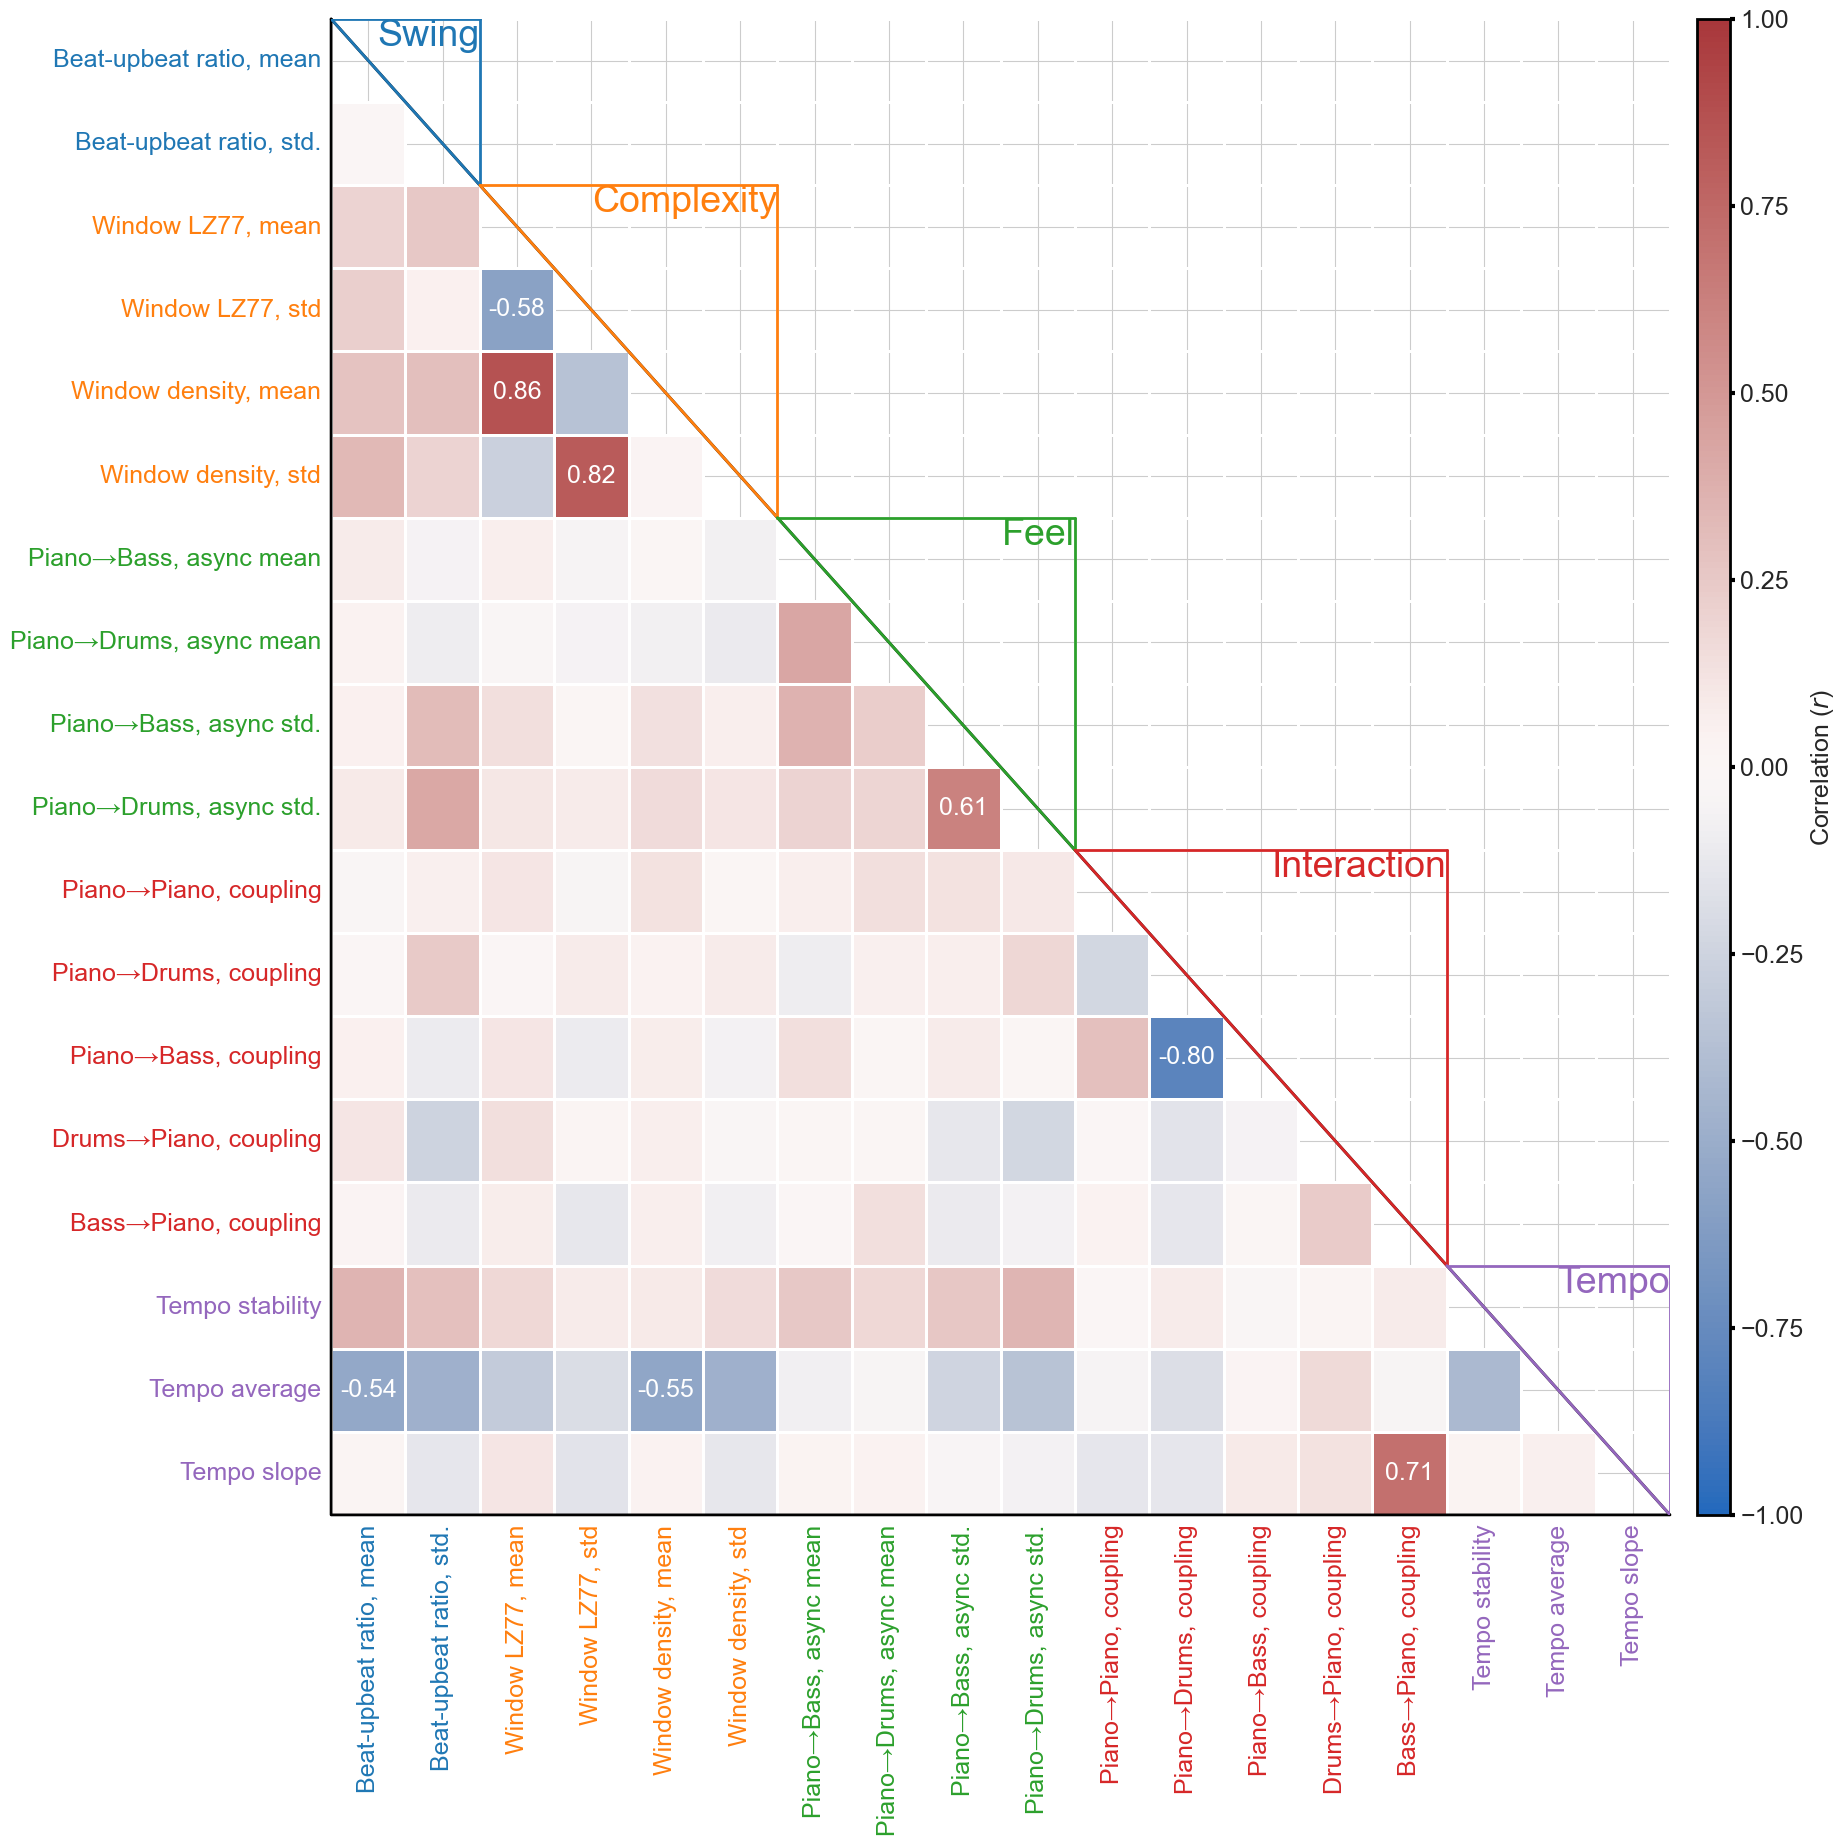

In [68]:
HeatMapFeatureCorrelation(df[PREDICTORS]).create_plot()
plt.show()

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [82]:
clean = df.copy(deep=True)

In [83]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [84]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_piano_{col}'] = np.nan

We clean `bur_log_mean` and `bur_log)std` when `-2 <= average_bur <= 2` (these are the values discussed by Corcoran and Frieler) OR `bur_log_count_nonzero < 15` (we have fewer than 15 BURs in the track).

In [85]:
for col in ['bur_log_mean', 'bur_log_std']:
    clean.loc[clean['bur_log_mean'] < -2, col] = np.nan
    clean.loc[clean['bur_log_mean'] > 2, col] = np.nan
    clean.loc[clean['bur_log_count_nonzero'] < 15, col] = np.nan

We clean `bass/drums_prop_async` when `piano_prop_async_count_nonzero < 10`, i.e. we have fewer than 10 beat asynchronies

In [86]:
for col in ['bass', 'drums']:
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanmean'] = np.nan
    clean.loc[clean['prop_async_count_nonzero'] < 10, f'{col}_prop_async_nanstd'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [87]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_drift'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [88]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

## Get number of missing values per predictor
Let's see how many missing values we have per predictor variable

In [89]:
COL_MAPPING = {
    'bur_log_mean': 'Beat-upbeat ratio, mean',
    'bur_log_std': 'Beat-upbeat ratio, std.',
    'lz77_mean': 'Window LZ77, mean',
    'lz77_std': 'Window LZ77, std',
    'n_onsets_mean': 'Window density, mean',
    'n_onsets_std': 'Window density, std',
    'bass_prop_async_nanmean': 'Piano→Bass, async mean',
    'bass_prop_async_nanstd': 'Piano→Bass, async std.',
    'drums_prop_async_nanmean': 'Piano→Drums, async mean',
    'drums_prop_async_nanstd': 'Piano→Drums, async std.',
    'coupling_bass': 'Piano→Bass, coupling',
    'coupling_piano_bass': 'Bass→Piano, coupling',
    'coupling_drums': 'Piano→Drums, coupling',
    'coupling_piano_drums': 'Drums→Piano, coupling',
    'self_coupling': 'Piano→Piano, coupling',
    'rolling_std_median': 'Tempo stability',
    'tempo': 'Tempo average',
    'tempo_slope': 'Tempo slope',
}

In [49]:
miss = clean[PREDICTORS].isna().sum().reset_index()
miss['cat'] = miss['index'].map(CATEGORY_MAPPING)
print(miss)

                       index    0          cat
0               bur_log_mean   15        Swing
1                bur_log_std   15        Swing
2                  lz77_mean    2   Complexity
3                   lz77_std    2   Complexity
4              n_onsets_mean    2   Complexity
5               n_onsets_std    2   Complexity
6    bass_prop_async_nanmean   12         Feel
7   drums_prop_async_nanmean    3         Feel
8     bass_prop_async_nanstd   12         Feel
9    drums_prop_async_nanstd    3         Feel
10             self_coupling  128  Interaction
11            coupling_drums  128  Interaction
12             coupling_bass  128  Interaction
13      coupling_piano_drums   71  Interaction
14       coupling_piano_bass   95  Interaction
15        rolling_std_median    8        Tempo
16                     tempo    0        Tempo
17               tempo_slope   24        Tempo


In [50]:
print(miss.groupby('cat')[0].mean() / 300)

cat
Complexity     0.006667
Feel           0.025000
Interaction    0.366667
Swing          0.050000
Tempo          0.035556
Name: 0, dtype: float64


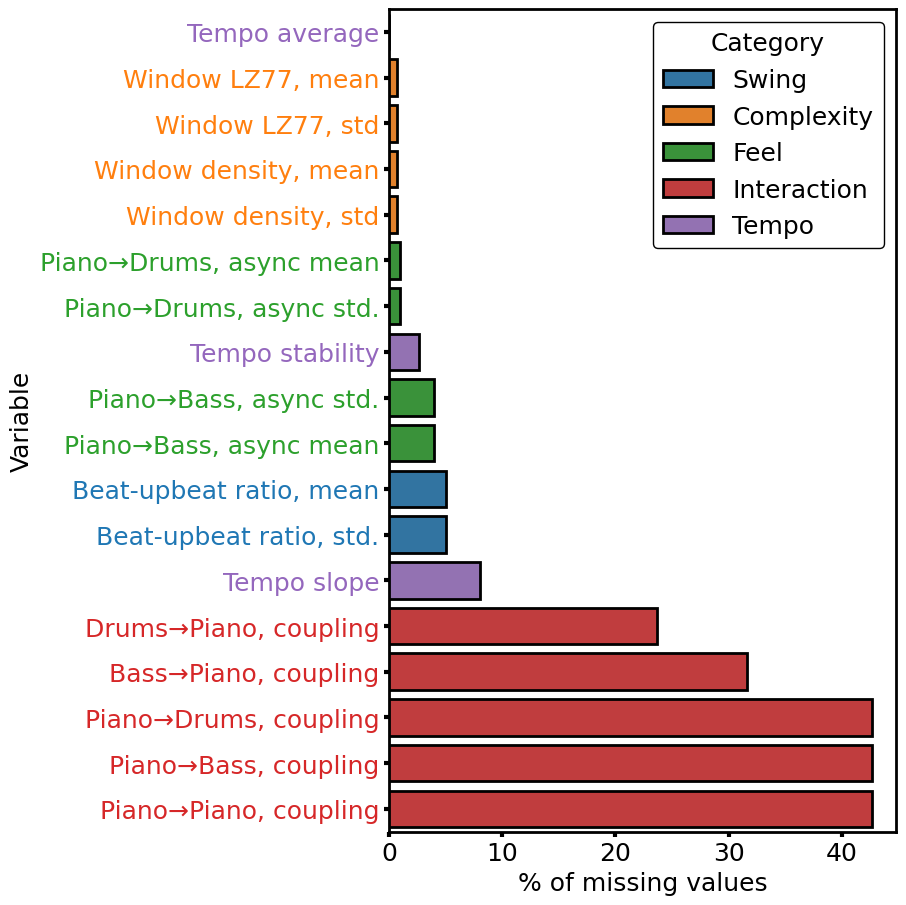

In [23]:
CountPlotMissingValues(clean[PREDICTORS], CATEGORY_MAPPING).create_plot()
plt.show()

In [60]:
jm = clean['coupling_piano_bass'].dropna()
means = [jm.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.quantile(means, 0.025), np.quantile(means, 0.975))

0.12021704090277989 0.15953866763195376


### Impute missing values based on feature average
We can now set missing values to the average for that feature across the entire dataset.

In [65]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())

In [66]:
X.corr()

,bur_log_mean,bur_log_std,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,bass_prop_async_nanmean,drums_prop_async_nanmean,bass_prop_async_nanstd,drums_prop_async_nanstd,self_coupling,coupling_drums,coupling_bass,coupling_piano_drums,coupling_piano_bass,rolling_std_median,tempo,tempo_slope
bur_log_mean,1.000000,0.018120,0.082715,0.204238,0.226131,0.297831,0.114162,0.036279,0.066406,0.113081,0.060446,0.118495,-0.005110,-0.113854,-0.000291,0.280378,-0.589054,-0.129564
bur_log_std,0.018120,1.000000,0.255293,0.050245,0.314702,0.220821,-0.052244,-0.100675,0.311556,0.414808,0.171244,0.215781,0.069454,-0.231379,-0.182571,0.241390,-0.507515,-0.237513
lz77_mean,0.082715,0.255293,1.000000,-0.582117,0.861500,-0.268689,0.076048,-0.035046,0.136428,0.099194,0.053057,0.147420,-0.048267,-0.098009,-0.051004,0.263386,-0.301522,0.052998
lz77_std,0.204238,0.050245,-0.582117,1.000000,-0.365285,0.815524,-0.046882,-0.070843,0.008033,0.079786,0.085757,0.020402,-0.009943,-0.013879,-0.010720,0.017084,-0.192703,-0.133105
n_onsets_mean,0.226131,0.314702,0.861500,-0.365285,1.000000,0.023730,0.011558,-0.088717,0.136169,0.155745,0.115969,0.203515,-0.066836,-0.079407,-0.056865,0.148304,-0.552648,-0.035297
n_onsets_std,0.297831,0.220821,-0.268689,0.815524,0.023730,1.000000,-0.070061,-0.125504,0.063671,0.111693,0.109569,0.087607,-0.064340,-0.071587,-0.043647,0.086381,-0.481210,-0.191055
bass_prop_async_nanmean,0.114162,-0.052244,0.076048,-0.046882,0.011558,-0.070061,1.000000,0.422543,0.366270,0.193774,0.016178,-0.066147,0.149305,-0.106844,-0.060109,0.291059,-0.080852,-0.089086
drums_prop_async_nanmean,0.036279,-0.100675,-0.035046,-0.070843,-0.088717,-0.125504,0.422543,1.000000,0.228394,0.192800,0.014833,-0.031501,0.030995,-0.119702,-0.106059,0.185899,-0.043930,-0.141394
bass_prop_async_nanstd,0.066406,0.311556,0.136428,0.008033,0.136169,0.063671,0.366270,0.228394,1.000000,0.589656,0.155206,0.077507,0.225267,-0.341522,-0.382695,0.275559,-0.244437,-0.249679
drums_prop_async_nanstd,0.113081,0.414808,0.099194,0.079786,0.155745,0.111693,0.193774,0.192800,0.589656,1.000000,0.138755,0.254064,0.009367,-0.428103,-0.318067,0.310387,-0.357435,-0.176553


Let's check that we've filled all missing values

In [25]:
print(X.isna().values.any())

False


### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [26]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling (new)
### Create the model class

In [27]:
class RandomForestFit:
    """Provides a wrapper around `StratifiedKFold` and `RandomForestClassifier`"""
    def __init__(self, params: dict = None):
        self.params = params if params is not None else {}
        # I think we can probably shuffle the data first.
        # The data is unordered (not time-series), so unlikely to have a negative effect
        self.skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        self.predicts, self.importances = [], []
        self.trees = []

    def fit_model(self, x_data, y_data):
        fits = [self._fit_model(x_data, y_data, x_idx, y_idx) for x_idx, y_idx in self.skf.split(x_data, y_data)]
        predicts, importances = list(zip(*fits))
        self.predicts = self._format_predicts_df(predicts)
        self.importances = self._format_importances_df(importances)
        return self

    def get_global_accuracy(self) -> float:
        """Returns the percentage of correct predictions"""
        return self.predicts['correct'].value_counts(normalize=True)[True]

    @staticmethod
    def _format_importances_df(importances) -> pd.DataFrame:
        importances_df_ = (
            pd.concat(importances, axis=1)
            .reset_index(drop=False)
            .rename(columns={'index': 'feature'})
        )
        importances_df_['category'] = importances_df_['feature'].map(CATEGORY_MAPPING)
        return importances_df_

    @staticmethod
    def _format_predicts_df(predicts) -> pd.DataFrame:
        predict_df_ = (
            pd.concat(predicts, axis=0)
            .sort_index()
            .rename(columns={0: 'prediction', 'pianist': 'actual'})
        )
        predict_df_['correct'] = predict_df_['prediction'] == predict_df_['actual']
        for var in ['prediction', 'actual']:
            predict_df_[var] = predict_df_[var].map({i: val for i, val in enumerate(pianist_labels)})
        return predict_df_

    def _fit_model(self, x_data, y_data, train_idx, test_idx):
        # Get our splits for this fold
        X_train, X_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        # Create the random forest model
        rf = RandomForestClassifier(random_state=SEED, **self.params)
        # Fit the random forest to the training data
        rf.fit(X_train, y_train)
        self.trees.append(rf)
        # Predict the test data
        y_predict = rf.predict(X_test)
        # Get prediction probabilities
        y_probs = rf.predict_proba(X_test)
        # Return the prediction and feature importance dataframes
        return (
            self._format_predict_df(y_predict, y_probs, y_test),
            pd.Series(rf.feature_importances_, index=X.columns)
        )

    @staticmethod
    def _format_predict_df(predict, predict_probs, actual):
        y_probs = pd.DataFrame(predict_probs)
        y_probs.columns = y_probs.columns.map({i: val for i, val in enumerate(pianist_labels)})
        y_probs.index = actual.index
        # Format the prediction series
        y_predict_s = pd.Series(predict)
        y_predict_s.index = actual.index
        # Concatenate the predicted and actual pianist
        return pd.concat([y_predict_s, actual, y_probs], axis=1)

### Get baseline accuracy
Here, we just guess a random pianist for each track

In [100]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {accuracy_random}")

Random guess accuracy: 0.10333333333333333


As you'd expect with 10 pianists and 30 tracks per pianist, we'll be correct approximately one in ten times if we just guess the pianist at random.

### Fit the initial model and get accuracy
Here we just use the default parameters for fitting the model

In [101]:
rf_init = RandomForestFit().fit_model(X, y)
print(f'Initial model accuracy: {rf_init.get_global_accuracy()}')

Initial model accuracy: 0.49333333333333335


### Parameter optimization
Now, we can try and optimize the model using a randomized search over an array of parameters

In [32]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(10, 1001, 1)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(1, 101, 1)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(2, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [33]:
# Create the `ParameterSampler` object for the required number of iterations
sampler = ParameterSampler(test_params, n_iter=N_ITER, random_state=SEED)

In [30]:
def get_cached_tracks() -> list:
    """Tries to get cached optimised parameters, returns an empty list if cannot find"""
    try:
        return utils.load_csv(
            fpath=rf"{utils.get_project_root()}\references\parameter_optimisation\corpus_chronology",
            fname='random_forest_opt'
        )
    except FileNotFoundError:
        return []

In [33]:
def create_forest(parameters: dict, iteration: int,):
    """Conducts one iteration of parameter optimisation, with given parameter"""
    # Check our cache to see if we've already got results for this iteration
    # As we use a set seed with `ParameterSampler`, we can get results with just the counter
    cached_results = get_cached_tracks()
    try:
        cached_res = [o for o in cached_results if o['iteration'] == iteration][0]
        # assert all(k in cached_res and parameters[k] == cached_res[k] for k in to_check)
    except (IndexError, AssertionError):
        pass
    else:
        return cached_res

    # Create the forest model
    forest = RandomForestFit(params=parameters)
    # Fit the model to the data
    forest.fit_model(X, y)
    # Create the results dictionary and save
    results_dict = {
        'accuracy': forest.get_global_accuracy(),
        'iteration': iteration,
        **parameters
    }
    utils.save_csv(
        results_dict,
        rf"{utils.get_project_root()}\references\parameter_optimisation\corpus_chronology",
        'random_forest_opt'
    )
    # Return the fitted forest object
    return results_dict

In [ ]:
# Use lazy parallelization to create the forest and fit to the data
with Parallel(n_jobs=N_JOBS, verbose=11) as parallel:
    rfs_fitted = parallel(delayed(create_forest)(params, num) for num, params in enumerate(sampler))

### Get the optimized parameters

In [ ]:
# Create a dataframe of parameters and accuracy scores
opt_df = pd.DataFrame(rfs_fitted)
opt_df.head()

In [187]:
# Get the parameter combination that yielded the best accuracy
best_params = opt_df[opt_df['accuracy'] == opt_df['accuracy'].max()][test_params.keys()].to_dict('records')[0]
best_params['max_depth'] = int(best_params['max_depth'])

So the optimization process doesn't have to be re-run each time, the final parameter set is given below in plain text:

`{
    'n_estimators': 50,
    'max_features': 'log2',
    'max_depth': 30,
    'bootstrap': True,
    'min_samples_leaf': 1,
    'min_samples_split': 2
 }`

### Fit the optimized model and get accuracy
Now, we use the best combination of parameters from our optimization process

In [28]:
BEST_PARAMS = {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [29]:
rf_opt = RandomForestFit(params=BEST_PARAMS).fit_model(X, y)
print(f'Optimized model accuracy: {rf_opt.get_global_accuracy()}')

Optimized model accuracy: 0.52


## Plot results
### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

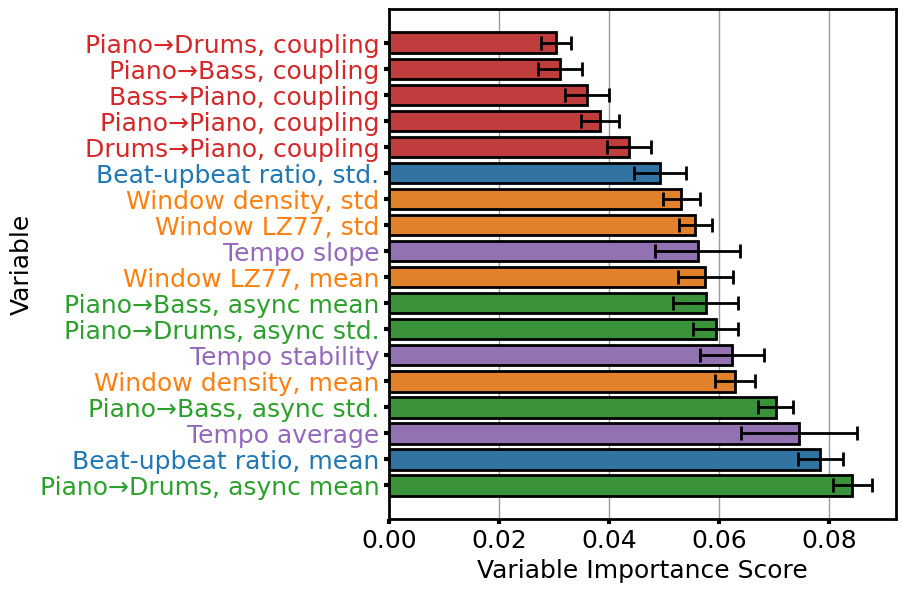

In [29]:
BarPlotFeatureImportances(rf_opt.importances).create_plot()
plt.show()

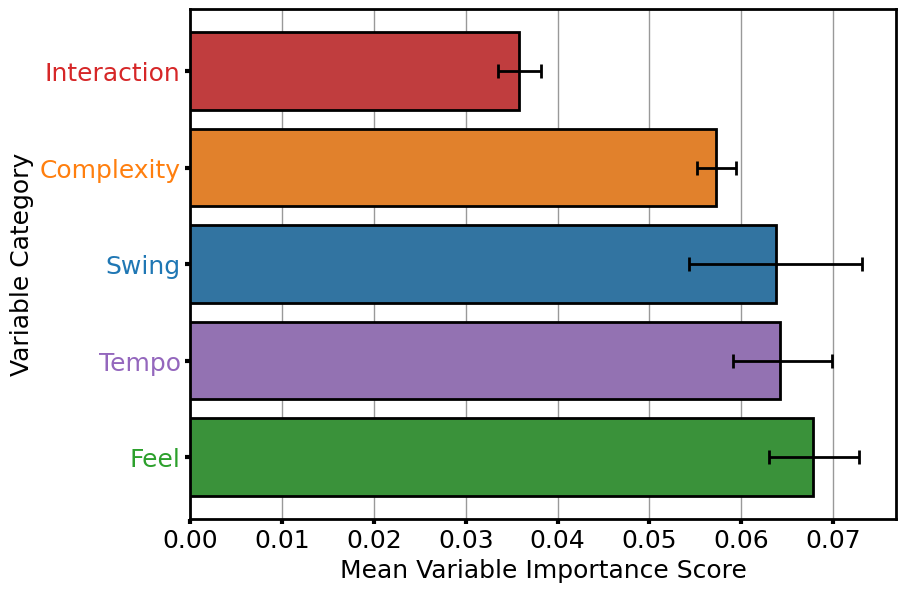

In [30]:
BarPlotCategoryImportances(rf_opt.importances).create_plot()
plt.show()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

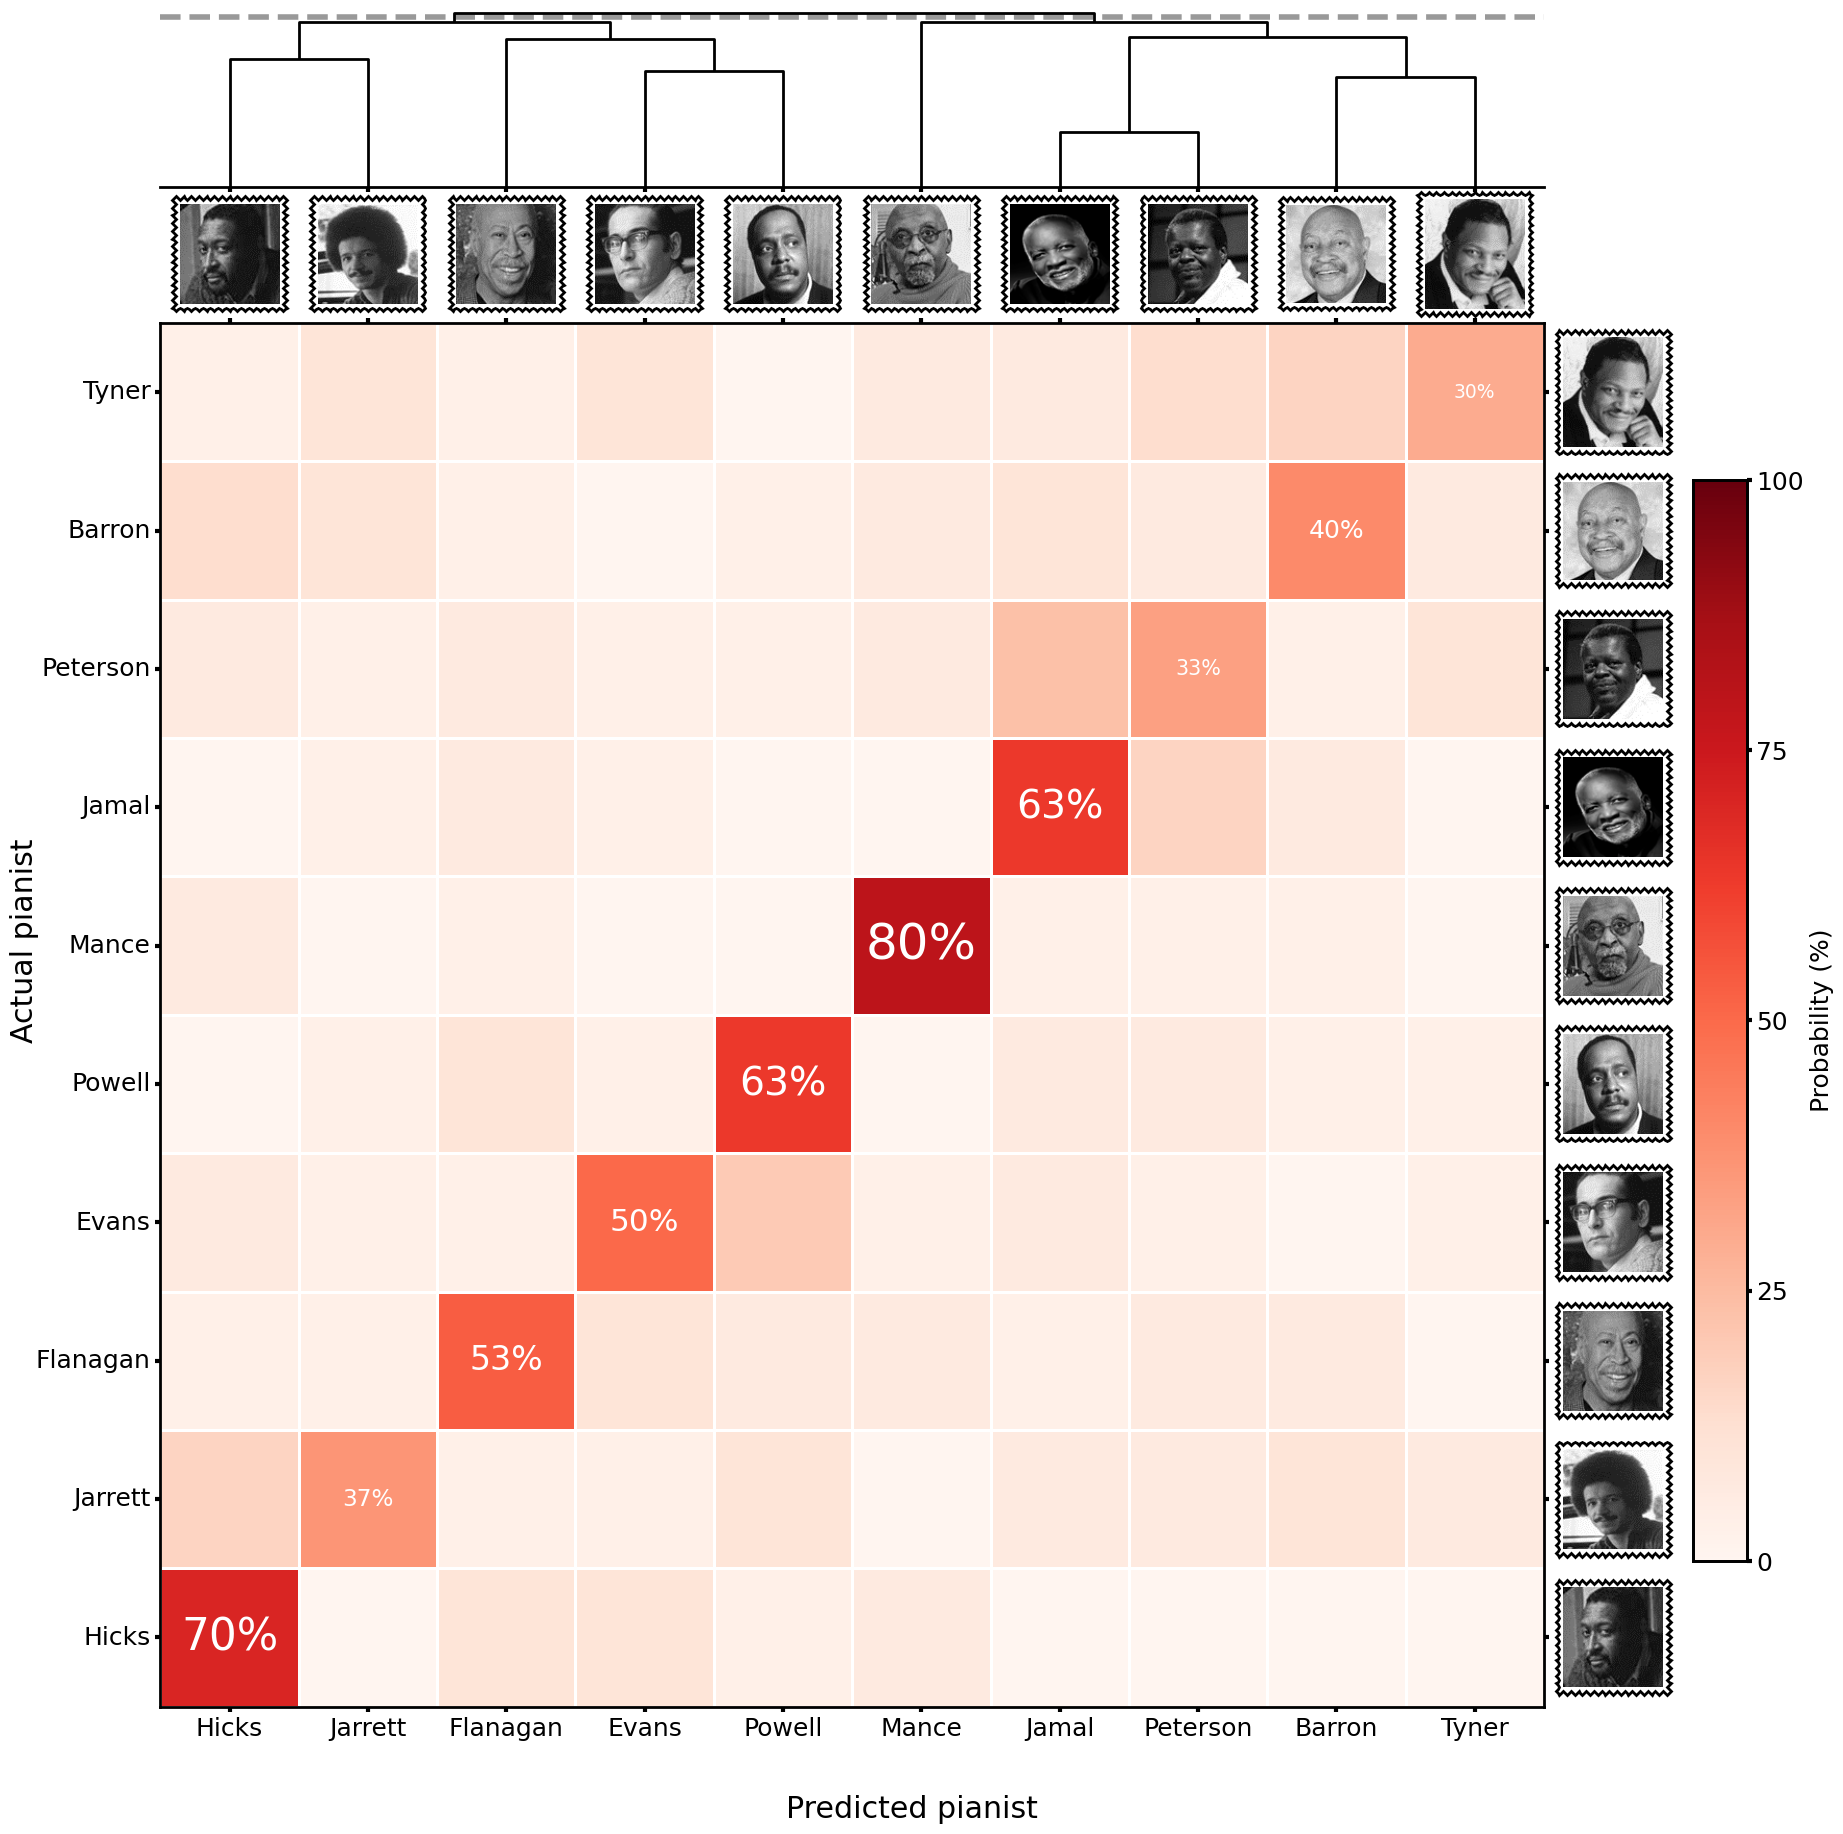

In [40]:
HeatMapPredictionProbDendro(rf_opt.predicts).create_plot()
plt.show()

### Get accuracy scores
Mean accuracy, top-k (`k=3`) accuracy, Cohen's kappa

In [29]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score, cohen_kappa_score, confusion_matrix
act = rf_opt.predicts['actual'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
pred = rf_opt.predicts['prediction'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
probs = rf_opt.predicts[pianist_labels].values
print('Mean accuracy:', accuracy_score(act, pred))
print('Top-k accuracy:', top_k_accuracy_score(act, probs, k=3))
print('Cohen kappa:', cohen_kappa_score(act, pred))

Mean accuracy: 0.52
Top-k accuracy: 0.76
Cohen kappa: 0.4666666666666668


In [32]:
cm = pd.DataFrame(confusion_matrix(act, pred, normalize='true'))
cm.index = pianist_labels
cm.columns = pianist_labels
cm

,Ahmad Jamal,Bill Evans,Bud Powell,John Hicks,Junior Mance,Keith Jarrett,Kenny Barron,McCoy Tyner,Oscar Peterson,Tommy Flanagan
Ahmad Jamal,0.633333,0.033333,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.166667,0.066667
Bill Evans,0.066667,0.500000,0.200000,0.066667,0.033333,0.033333,0.000000,0.033333,0.033333,0.033333
Bud Powell,0.066667,0.033333,0.633333,0.000000,0.000000,0.033333,0.033333,0.033333,0.066667,0.100000
John Hicks,0.000000,0.100000,0.033333,0.700000,0.066667,0.000000,0.000000,0.000000,0.000000,0.100000
Junior Mance,0.033333,0.000000,0.000000,0.066667,0.800000,0.000000,0.033333,0.000000,0.033333,0.033333
Keith Jarrett,0.066667,0.033333,0.100000,0.166667,0.000000,0.366667,0.100000,0.066667,0.066667,0.033333
Kenny Barron,0.100000,0.000000,0.033333,0.133333,0.066667,0.100000,0.400000,0.066667,0.066667,0.033333
McCoy Tyner,0.066667,0.100000,0.000000,0.033333,0.066667,0.100000,0.166667,0.300000,0.133333,0.033333
Oscar Peterson,0.233333,0.033333,0.033333,0.066667,0.066667,0.033333,0.033333,0.100000,0.333333,0.066667
Tommy Flanagan,0.033333,0.100000,0.066667,0.033333,0.066667,0.033333,0.066667,0.000000,0.066667,0.533333


### Get feature importances
Average importance per feature, per category

In [33]:
imp_feat = (
    rf_opt.importances.copy(deep=True)
    .melt(id_vars=['feature', 'category'])
    .groupby('feature')
    ['value']
    .mean()
    .sort_values()
)
imp_feat

feature
coupling_drums              0.030334
coupling_bass               0.031053
coupling_piano_bass         0.035984
self_coupling               0.038318
coupling_piano_drums        0.043566
bur_log_std                 0.049270
n_onsets_std                0.053129
lz77_std                    0.055635
tempo_slope                 0.056059
lz77_mean                   0.057455
bass_prop_async_nanmean     0.057532
drums_prop_async_nanstd     0.059334
rolling_std_median          0.062254
n_onsets_mean               0.062854
bass_prop_async_nanstd      0.070221
tempo                       0.074493
bur_log_mean                0.078360
drums_prop_async_nanmean    0.084150
Name: value, dtype: float64

In [34]:
imp_cat = (
    rf_opt.importances.copy(deep=True)
    .melt(id_vars=['feature', 'category'])
    .groupby('category')
    ['value']
    .mean()
    .sort_values()
)
imp_cat

category
Interaction    0.035851
Complexity     0.057268
Swing          0.063815
Tempo          0.064269
Feel           0.067809
Name: value, dtype: float64

## Predicting first and last recordings

In [57]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

In [58]:
clean['recording_year_'] = clean['recording_year'].astype(int)

In [216]:
min_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=True)
    .groupby('pianist')
    .head(6)
    .index
    .sort_values()
    .to_numpy()
)
max_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=False)
    .groupby('pianist')
    .head(6)
    .index
    .sort_values()
    .to_numpy()
)

In [217]:
def minmax_acc(test_idx) -> float:
    train_idx = np.sort(np.array([*(set(X.index) - set(test_idx))]))
    assert not set(test_idx).issubset(set(train_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Create the random forest model
    rf_fl = RandomForestClassifier(random_state=SEED, **BEST_PARAMS)
    # Fit the random forest to the training data
    rf_fl.fit(X_train, y_train)
    fl_pred = rf_fl.predict(X_test)
    # Get accuracy for predicting the set
    return accuracy_score(y_test, fl_pred)

min_acc = minmax_acc(min_idxs)
max_acc = minmax_acc(max_idxs)

0.4
0.4666666666666667


In [202]:
def permute_model(rand_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rand_state)
    # Create the random forest model
    rf_rand = RandomForestClassifier(random_state=SEED, **BEST_PARAMS)
    # Fit the random forest to the training data
    rf_rand.fit(X_train, y_train)
    rand_pred = rf_rand.predict(X_test)
    return accuracy_score(y_test, rand_pred)

In [203]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    accs = parallel(delayed(permute_model)(state) for state in range(vutils.N_BOOT))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

C:\Users\huwch\AppData\Local\Temp\ipykernel_20548\2095453251.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set(


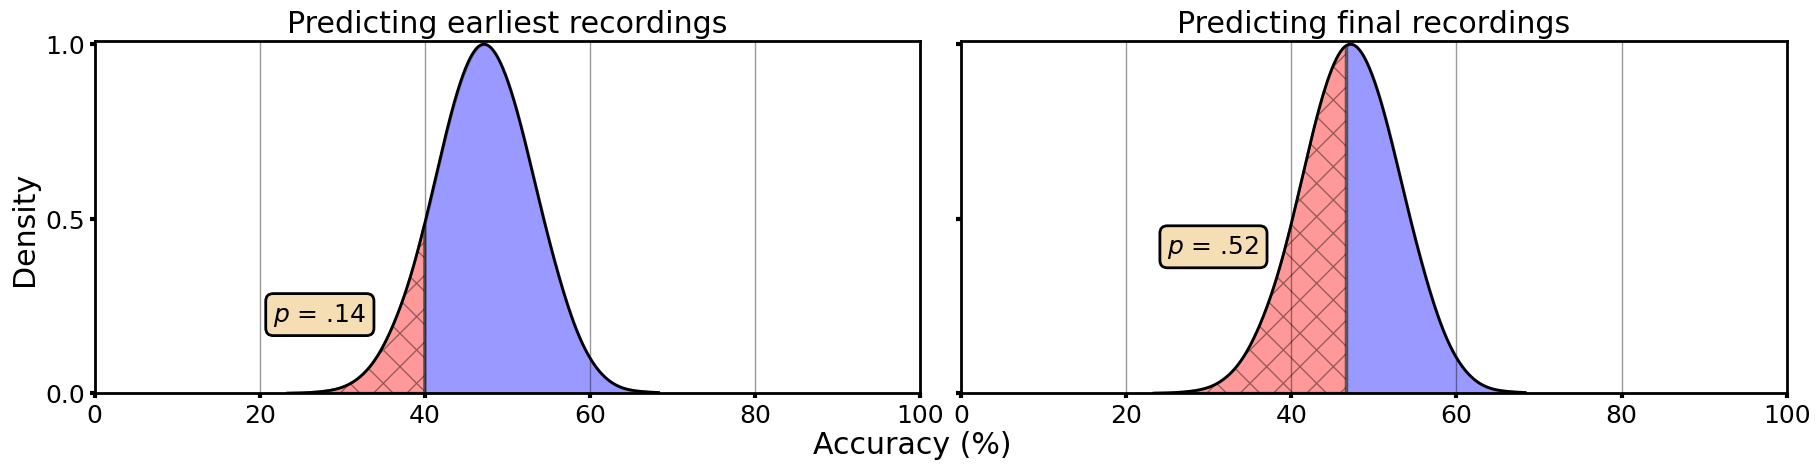

In [281]:
HistPlotFirstLastP(accs, min_acc, max_acc).create_plot()
plt.show()

## Regressions of age vs strongest predictors

In [295]:
def career_proportion(grp):
    return np.array((grp - np.min(grp)) / (np.max(grp) - np.min(grp)))

clean['career_progress'] = clean.groupby('pianist')['recording_year_'].transform(career_proportion)

In [393]:
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

predictors = ['drums_prop_async_nanmean', 'tempo', 'bur_log_mean', 'n_onsets_mean', 'coupling_piano_drums']
conr = []
marr = []
for predict in predictors:
    vars_ = [predict, 'pianist', 'career_progress']
    data = clean[vars_].dropna()
    md = smf.mixedlm(f'{predict}~career_progress', groups=data['pianist'], data=data, re_formula='~career_progress').fit()
    print(md.summary())
    # Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
    var_fixed = md.predict().var()
    # Variance explained by the random effects
    var_random = float(md.cov_re.to_numpy().mean())
    # Variance of the residuals
    var_resid = md.scale
    # Total variance of the model
    total_var = var_fixed + var_random + var_resid
    # Calculate the r2 values and append to the model
    conr.append((var_fixed + var_random) / total_var)
    marr.append(var_fixed / total_var)
print('mean conditional r2', np.mean(conr) * 100, 'stdev', np.std(conr) * 100)
print('mean marginal r2', np.mean(marr) * 100, 'stdev', np.std(marr) * 100)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: drums_prop_async_nanmean
No. Observations: 297     Method:             REML                    
No. Groups:       10      Scale:              0.0000                  
Min. group size:  28      Log-Likelihood:     1087.1027               
Max. group size:  30      Converged:          Yes                     
Mean group size:  29.7                                                
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.015    0.002  9.180 0.000  0.012  0.018
career_progress             -0.001    0.002 -0.310 0.757 -0.005  0.004
Group Var                    0.000    0.002                           
Group x career_progress Cov -0.000    0.003                           
career_progress Var    

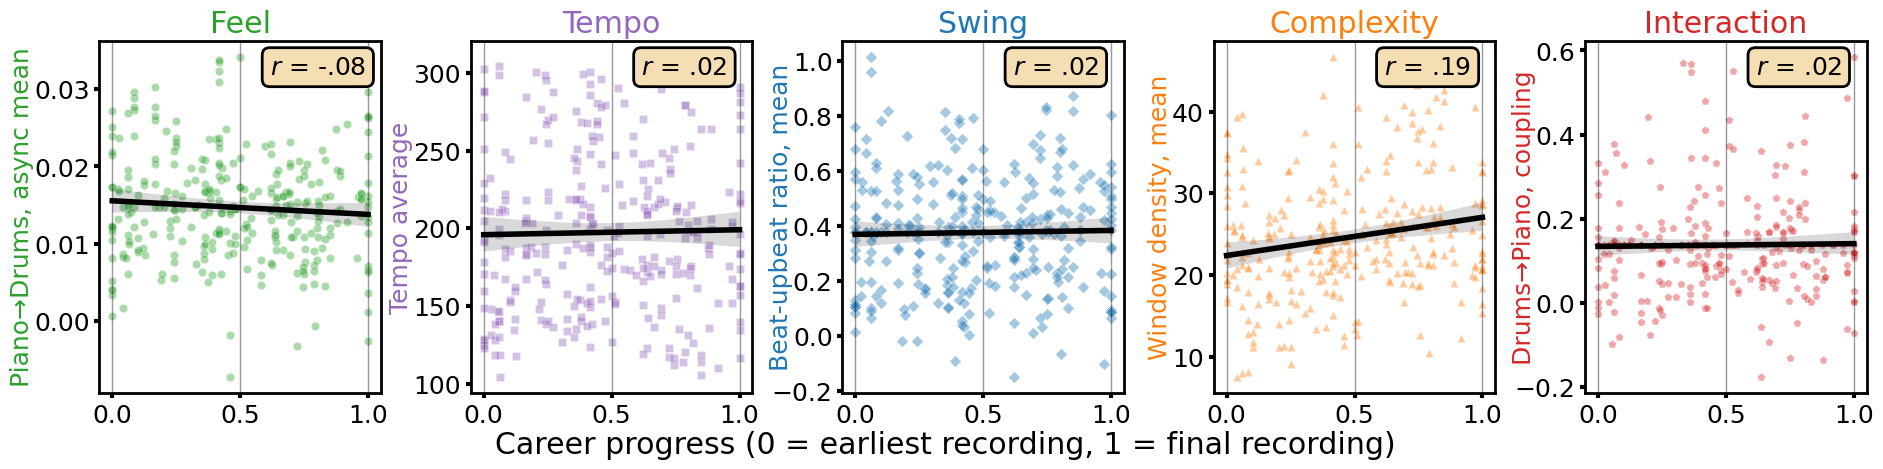

In [388]:
RegPlotPredictorsCareerProgress(clean).create_plot()
plt.show()

## Binary logistic regression of two clusters -- impressionistic vs blues

In [90]:
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

import src.visualise.visualise_utils as vutils

In [91]:
impression = ['Bill Evans', 'Bud Powell', 'John Hicks', 'Keith Jarrett', 'Tommy Flanagan']
bop = ['Ahmad Jamal', 'Junior Mance', 'Kenny Barron', 'McCoy Tyner', 'Oscar Peterson']

In [92]:
clean.loc[clean['pianist'].isin(impression), 'cluster'] = 0
clean.loc[clean['pianist'].isin(bop), 'cluster'] = 1

In [93]:
X = clean[reversed([
    'bass_prop_async_nanmean',
    'bass_prop_async_nanstd',
    'drums_prop_async_nanmean',
    'drums_prop_async_nanstd',
    'tempo',
    'tempo_slope',
    'rolling_std_median',
    'bur_log_mean',
    'bur_log_std',
    'n_onsets_mean',
    'n_onsets_std',
    'lz77_mean',
    'lz77_std',
    'self_coupling',
    'coupling_bass',
    'coupling_drums',
    'coupling_piano_bass',
    'coupling_piano_drums'
])]
X = X.fillna(X.mean()).apply(stats.zscore)
X = sm.add_constant(X)
y = clean['cluster'].astype(int)

In [94]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                       1.000000
coupling_piano_drums        1.434279
coupling_piano_bass         1.323919
coupling_drums              2.600280
coupling_bass               2.337764
self_coupling               1.439762
lz77_std                    5.806209
lz77_mean                   8.318691
n_onsets_std                5.539431
n_onsets_mean               9.179470
bur_log_std                 2.076519
bur_log_mean                1.989205
rolling_std_median          1.802553
tempo_slope                 1.233649
tempo                       4.879061
drums_prop_async_nanstd     2.060715
drums_prop_async_nanmean    1.380414
bass_prop_async_nanstd      2.104180
bass_prop_async_nanmean     1.474937
dtype: float64

In [95]:
md = sm.Logit(y, X).fit()
print(md.summary())

Optimization terminated successfully.
         Current function value: 0.527371
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                cluster   No. Observations:                  300
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                           18
Date:                Mon, 11 Dec 2023   Pseudo R-squ.:                  0.2392
Time:                        17:11:55   Log-Likelihood:                -158.21
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 2.775e-13
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0012      0.138      0.009      0.993      -0.270

In [96]:
y_pred = md.predict(X)
print(accuracy_score(y, y_pred.round().astype(int)))
print(roc_auc_score(y, y_pred))
print(roc_auc_score(y, np.random.choice([0, 1], 300)))

0.72
0.8164444444444445
0.4966666666666667


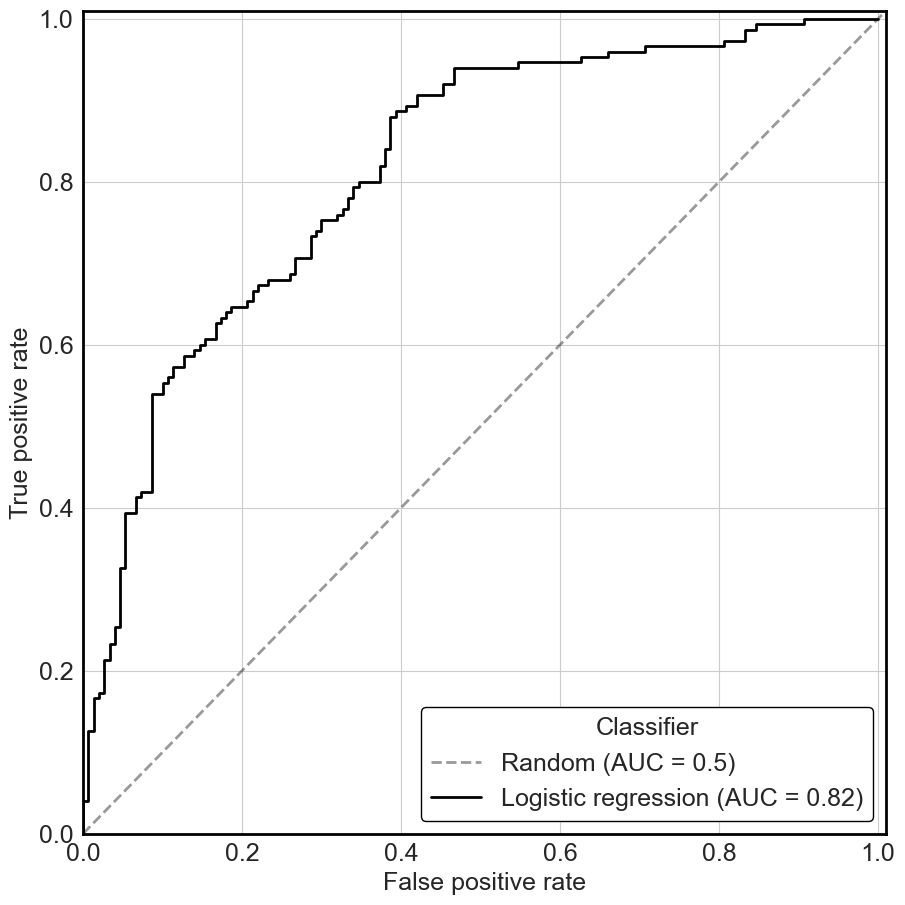

In [97]:
RocPlotLogRegression(y, y_pred).create_plot()
plt.show()

In [103]:
params = pd.concat([md.params.rename('coeff'), md.conf_int().rename(columns={0: 'low', 1: 'high'})], axis=1).apply(np.exp).reset_index(drop=False)[1:]
# params['low'] = params['coeff'] - params['low']
# params['high'] -= params['coeff']
params['category'] = params['index'].map(CATEGORY_MAPPING)

In [104]:
params

,index,coeff,low,high,category
1,coupling_piano_drums,0.876593,0.634122,1.211779,Interaction
2,coupling_piano_bass,1.661278,1.180680,2.337505,Interaction
3,coupling_drums,0.565610,0.353147,0.905897,Interaction
4,coupling_bass,0.455603,0.287301,0.722496,Interaction
5,self_coupling,1.893174,1.268086,2.826390,Interaction
6,lz77_std,1.519404,0.770156,2.997560,Complexity
7,lz77_mean,0.245566,0.103210,0.584271,Complexity
8,n_onsets_std,1.027802,0.508220,2.078582,Complexity
9,n_onsets_mean,6.460698,2.378831,17.546694,Complexity
10,bur_log_std,0.991520,0.669062,1.469388,Swing


C:\Python Projects\jazz-corpus-analysis\src\visualise\random_forest_plots.py:549: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK, rotation=0)


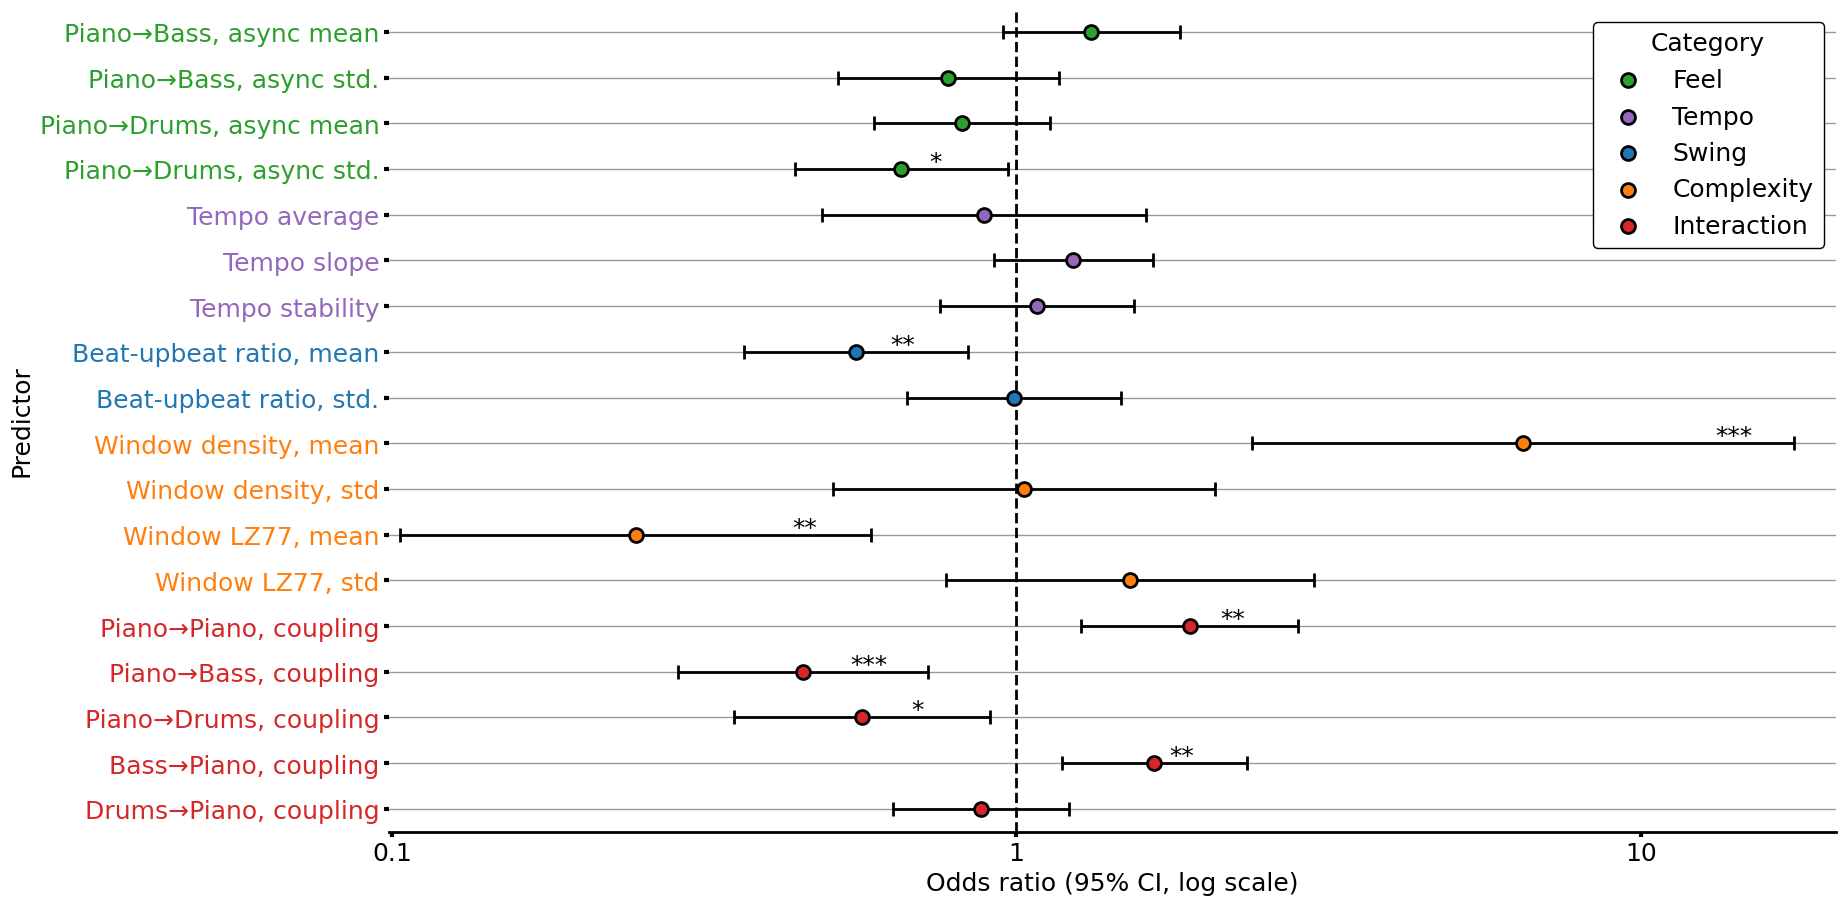

In [102]:
StripPlotLogitCoeffs(md, category_mapping=CATEGORY_MAPPING).create_plot()
plt.show()